In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import mglearn
from sklearn.model_selection import train_test_split

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/NanumBarunGothic.ttf').get_name()
rc('font',family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier # loss = 'deviance'
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [3]:
#cancer data
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer();
cX_train, cX_test, cy_train, cy_test = train_test_split(cancer.data, cancer.target,                                                  
                                                    random_state=0)

#moon data
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=500, random_state=42, noise=0.3)

mX_train, mX_test, my_train, my_test = train_test_split(X,y,random_state=42)

### Voting

- 여러 개의 모델이 투표함
- estimators = []에 분류기들을 넣고 사용
- voting = 'hard' 'soft'  / 직접, 간접 투표
- soft쓰려면 모든 모델이 확률 추정을 하는 것은 아니라 다른 작업 필요할 수도 있음

In [14]:
from sklearn.ensemble import VotingClassifier

#voting에 사용할 분류기들
clf1 = LogisticRegression(random_state=0, max_iter=2000)
clf2 = RandomForestClassifier(n_estimators=100, random_state=0)
clf3 = GaussianNB()
clf4 = DecisionTreeClassifier(random_state=0)


vt_hard = VotingClassifier(estimators=[('lo', clf1), ('rf', clf2), ('gn', clf3), ('dt', clf4)])
vt_soft = VotingClassifier(estimators=[('lo', clf1), ('rf', clf2), ('gn', clf3), ('dt', clf4)], voting='soft')



print("Cancer Data\n")
for clf in (clf1, clf2, clf3, clf4, vt_hard, vt_soft):
    clf.fit(cX_train, cy_train)
    print(clf.__class__.__name__, '{:.3f} , {:.3f}'.format(accuracy_score(cy_train, clf.predict(cX_train)),
                                                                          accuracy_score(cy_test, clf.predict(cX_test))))

print("\n\nMoon Data\n")
for clf in (clf1, clf2, clf3, clf4, vt_hard, vt_soft):
    clf.fit(mX_train, my_train)
    print(clf.__class__.__name__, '{:.3f} , {:.3f}'.format(accuracy_score(my_train, clf.predict(mX_train)),
                                                                          accuracy_score(my_test, clf.predict(mX_test))))


Cancer Data

LogisticRegression 0.960 , 0.951
RandomForestClassifier 1.000 , 0.972
GaussianNB 0.951 , 0.937
DecisionTreeClassifier 1.000 , 0.881
VotingClassifier 0.995 , 0.958
VotingClassifier 0.995 , 0.951


Moon Data

LogisticRegression 0.843 , 0.864
RandomForestClassifier 1.000 , 0.896
GaussianNB 0.840 , 0.856
DecisionTreeClassifier 1.000 , 0.888
VotingClassifier 0.923 , 0.856
VotingClassifier 0.968 , 0.920


위 voting model이 hard고 아래가 soft임

- 랜덤포레스트랑 결정트리는 과적합
- cancer data에서는 hard가 더 성능이 좋고 moon에선 soft가 더 높은 정확도를 가진다
- 데이터 성격에 따라서도 hard와 soft 사이에 차이가 있는 것 같다

### Bagging

In [17]:
from sklearn.ensemble import BaggingClassifier
#base_estimator = None (결정트리가 기본)

bc = BaggingClassifier(random_state=0).fit(cX_train, cy_train)
print("bagging 테스트 세트 정확도 : {:.3f}".format(bc.score(cX_test, cy_test)))

rf = RandomForestClassifier(random_state=0).fit(cX_train, cy_train)
print("random forest테스트 세트 정확도 : {:.3f}".format(rf.score(cX_test, cy_test)))

bagging 테스트 세트 정확도 : 0.972
random forest테스트 세트 정확도 : 0.972


random forest와 유사하지만 max_samples를 설정 가능하다
- max_samples = 부트 스트랩 샘플수
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

,train,test
0.1,0.946009,0.937063
0.3,0.978873,0.972028
0.5,0.978873,0.972028
0.7,0.988263,0.965035
1.0,0.626761,0.629371
3.0,0.856808,0.839161
5.0,0.903756,0.895105
10.0,0.913146,0.944056


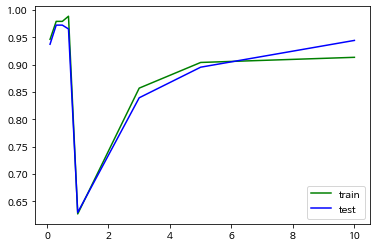

In [35]:
score = []
samples = [0.1,0.3,0.5,0.7,1,3,5,10]
for s in samples:
    bc = BaggingClassifier(random_state=0, max_samples=s).fit(cX_train, cy_train)
    score.append([bc.score(cX_train, cy_train),bc.score(cX_test, cy_test)])

df = pd.DataFrame(score, index=samples, columns = ["train","test"])
display(df)

score = np.array(score)

plt.plot(samples, score[:,0].reshape(-1,1), 'g-', label="train")
plt.plot(samples, score[:,1].reshape(-1,1), 'b-', label="test")
plt.legend()

#### max_samples에 따른 결과

- 정수면 그대로 사용하고, 실수면 max_samples * X.shape[0](샘플의 수)로 사용
- 정수면 그대로 사용이라서 max_samples = 1일때는 하나만 사용가능해서 정확도가 확 떨어진다
- 그 후 샘플수가 늘어나면서 정확도가 다시 오르는 것을 확인할 수 있다

### OOB Score

- 데이터가 적을 경우 검증 데이터로 사용가능. 테스트 데이터와는 다름
- bagging은 부트스트랩 샘플링 방식이라서 사용되지 않는 샘플들이 존재함
- 63 : 37 정도
- 이것들을 마지막 테스트 데이터로 사용하는 것
- oob_score = True로 설정하면 알아서 평가

In [36]:
bc = BaggingClassifier(DecisionTreeClassifier(), random_state=40, n_estimators=500,
                      bootstrap=True, oob_score=True).fit(cX_train,cy_train)

print("bagging 테스트 세트 정확도 : {:.3f}".format(bc.score(cX_test, cy_test)))
print("bagging oob score : ", (bc.oob_score_))
#accuracy_score(y_test, bc.predict(X_test))

#cancer

bagging 테스트 세트 정확도 : 0.972
bagging oob score :  0.9530516431924883


In [37]:
bc = BaggingClassifier(DecisionTreeClassifier(), random_state=40, n_estimators=500,
                      bootstrap=True, oob_score=True).fit(mX_train,my_train)

print("bagging 테스트 세트 정확도 : {:.3f}".format(bc.score(mX_test, my_test)))
print("bagging oob score : ", (bc.oob_score_))
#accuracy_score(y_test, bc.predict(X_test))

#moon

bagging 테스트 세트 정확도 : 0.912
bagging oob score :  0.8986666666666666


- oob 결과를 보니 실제 테스트 데이터의 결과와는 다른 것을 확인할 수 있음..

### Extratree

In [42]:
from sklearn.ensemble import ExtraTreesClassifier

exc = ExtraTreesClassifier(random_state=0).fit(mX_train, my_train)
print("훈련 세트 정확도 : {:.3f}".format(exc.score(mX_train, my_train)))
print("테스트 세트 정확도 : {:.3f}".format(exc.score(mX_test, my_test)))

훈련 세트 정확도 : 1.000
테스트 세트 정확도 : 0.896


In [41]:
rf = RandomForestClassifier(random_state=0).fit(mX_train, my_train)
print("훈련 세트 정확도 : {:.3f}".format(rf.score(mX_train, my_train)))
print("테스트 세트 정확도 : {:.3f}".format(rf.score(mX_test, my_test)))

훈련 세트 정확도 : 1.000
테스트 세트 정확도 : 0.896


- random forest보다 더 무작위성 주입
- 후보 특성 무작위 분할하고 다음 최적 분할 찾음
- 부트 스트랩 샘플링 안 씀 > 비복원추출
- 중복이 발생하지 않음


- https://blog.naver.com/jaemin408/221826591584


### Adaboosting

- 부스팅 방법
- 이전 모델이 잘못 분류한 샘플에 가중치 높여서 다음 모델 훈련


> base estimator
>- deicisiontreeclassifier > max_depth=1
>- decisiontreeRegressor > max_depth=3

In [52]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(random_state=0)
ada.fit(cX_train, cy_train)

print("훈련 세트 정확도 : {:.3f}".format(ada.score(cX_train, cy_train)))
print("테스트 세트 정확도 : {:.3f}".format(ada.score(cX_test, cy_test)))

#cancer

훈련 세트 정확도 : 1.000
테스트 세트 정확도 : 0.979


In [49]:
ada = AdaBoostClassifier(random_state=0).fit(mX_train, my_train)

print("훈련 세트 정확도 : {:.3f}".format(rf.score(mX_train, my_train)))
print("테스트 세트 정확도 : {:.3f}".format(rf.score(mX_test, my_test)))

훈련 세트 정확도 : 1.000
테스트 세트 정확도 : 0.896


부스팅 모델이라 과적합이 잘 된다

### XGBoost

- gradient boosting 최적화

In [45]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, use_label_encoder =False
                    ,max_depth=3, random_state=42, eval_metric='logloss')
xgb.fit(X_train, y_train)
accuracy_score(y_test, xgb.predict(X_test))



0.872

https://stackoverflow.com/questions/45251126/deprecation-warning-on-xgboost-sklearn

- xgb가 deprecated된 sklearn의 label 기능을 사용하고 있기 때문에
- use_label_encoder =False 하지 않으면 경고가 뜬다. 모델 성능에는 영향 없음

In [53]:
xgb = GradientBoostingClassifier(random_state=42).fit(cX_train, cy_train)

print("훈련 세트 정확도 : {:.3f}".format(xgb.score(cX_train, cy_train)))
print("테스트 세트 정확도 : {:.3f}".format(xgb.score(cX_test, cy_test)))

훈련 세트 정확도 : 1.000
테스트 세트 정확도 : 0.972


In [54]:
xgb = GradientBoostingClassifier(random_state=42).fit(mX_train, my_train)

print("훈련 세트 정확도 : {:.3f}".format(xgb.score(mX_train, my_train)))
print("테스트 세트 정확도 : {:.3f}".format(xgb.score(mX_test, my_test)))

훈련 세트 정확도 : 0.979
테스트 세트 정확도 : 0.888
